<h1><center>Polio cases analisis and predictions</center></h1>

Smart introduction #TODO

<h3>Imports</h3>

In [1]:
from cmdstanpy import CmdStanModel, CmdStanMCMC

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import time

global_seed = 29042020

<h3>Used Functions</h3>

In [48]:
def select_data(country: str, n_last_years: int = None) -> pd.DataFrame:
    import_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
    if n_last_years:
        selected_data = import_data[import_data['Entity'] == country][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-n_last_years-1:-1]
    else:
        selected_data = import_data[import_data['Entity'] == country][['Year','Total (reported) polio cases','Total (estimated) polio cases']][:-1]
    selected_data.rename(columns = {'Total (reported) polio cases': 'Cases'}, inplace=True)
    selected_data.rename(columns= {'Total (estimated) polio cases':'Cases_estimated'}, inplace=True)
    return selected_data

def plot_selected_data(selected_data: pd.DataFrame) -> None:
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.legend(['Total (reported) polio cases for selected data'], prop={'size': 20})
    plt.xlabel('Year')
    plt.ylabel('Number of cases')
    plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
    fit = np.polyfit(selected_data['Year'], selected_data['Cases'], 1)
    plt.plot(selected_data['Year'], fit[0]*selected_data['Year']+fit[1])
    plt.show()
    
def plot_distributions(fitted_model: CmdStanMCMC) -> None:
    plt.figure(figsize=(26, 6))
    plt.grid(True)
    plt.subplot(131)
    plt.hist(fitted_model.stan_variable('alpha'), bins = 20, density = True)
    plt.title('Alpha distribution')
    plt.subplot(132)
    plt.hist(fitted_model.stan_variable('beta'), bins = 20, density = True)
    plt.title('Beta distribution')
    plt.subplot(133)
    plt.hist(fitted_model.stan_variable('sigma'), bins = 20, density = True)
    plt.title('Sigma distribution')
    plt.show()
    
def plot_predictions_chart(selected_data: pd.DataFrame, pred_variable: np.ndarray, pred_year: int|str, quantiles: bool = True):
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.plot([pred_year-1, pred_year], [selected_data['Cases'].iloc[-1], int(np.mean(pred_variable))], linewidth=5)
    if quantiles:
        plt.scatter(pred_year,np.quantile(pred_variable,0.95), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.75), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.5), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.25), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.05), linewidth=0.5)
        plt.legend(['Total polio cases [imported data]','Total predicted (estimated) polio cases', 'Quantile 0.95', 'Quantile 0.75','Quantile 0.5','Quantile 0.25','Quantile 0.05'], prop={'size': 20})
    else:
        plt.legend(['Total polio cases [imported data]','Total predicted (estimated) polio cases'], prop={'size': 20})
    plt.title('Model chart with predicted data')
    plt.show()
    print(f'Predicted mean value of Polio cases for year {pred_year}: {int(np.mean(pred_variable))}')

<h3>Importing world data</h3>

Source: https://ourworldindata.org/polio 

In [3]:
imported_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
world_data = imported_data[imported_data['Entity'] == 'World'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][:-1]  #2021 data is incomplete
world_data.reset_index(inplace=True)
world_data.describe()

,index,Year,Total (reported) polio cases,Total (estimated) polio cases
count,41.000000,41.000000,41.000000,41.000000
mean,7642.000000,2000.000000,13153.390244,87584.902439
std,11.979149,11.979149,17926.259126,126481.340420
min,7622.000000,1980.000000,42.000000,49.000000
25%,7632.000000,1990.000000,784.000000,1139.000000
50%,7642.000000,2000.000000,2971.000000,20797.000000
75%,7652.000000,2010.000000,23053.000000,131538.000000
max,7662.000000,2020.000000,65737.000000,460159.000000


<h3>Print imported data</h3>

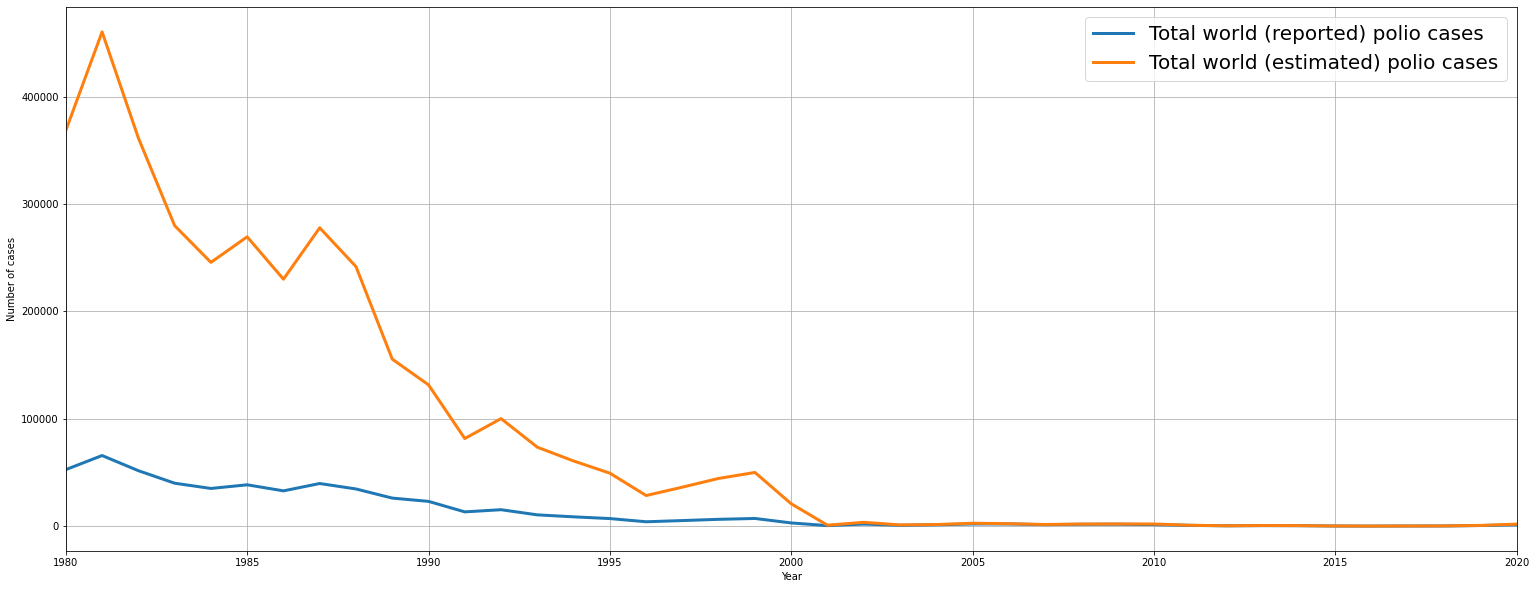

In [4]:
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(world_data['Year'],world_data['Total (reported) polio cases'],linewidth=3)
plt.plot(world_data['Year'],world_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Total world (reported) polio cases','Total world (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(world_data['Year']),max(world_data['Year']))
plt.show()

Looking at global data from the past 40 years it seems that polio was successfully stopped, hoever, closer inspection to the past few years is necessary to understand growing problem.

In [5]:
selected_world_data = world_data[-15:]
print(selected_world_data)

    index  Year  Total (reported) polio cases  Total (estimated) polio cases
26   7648  2006                          2022                         2247.0
27   7649  2007                          1387                         1540.0
28   7650  2008                          1736                         1927.0
29   7651  2009                          1787                         2020.0
30   7652  2010                          1412                         1988.0
31   7653  2011                           716                          827.0
32   7654  2012                           293                          326.0
33   7655  2013                           481                          565.0
34   7656  2014                           415                          470.0
35   7657  2015                           106                          140.0
36   7658  2016                            42                           49.0
37   7659  2017                           118                          131.0

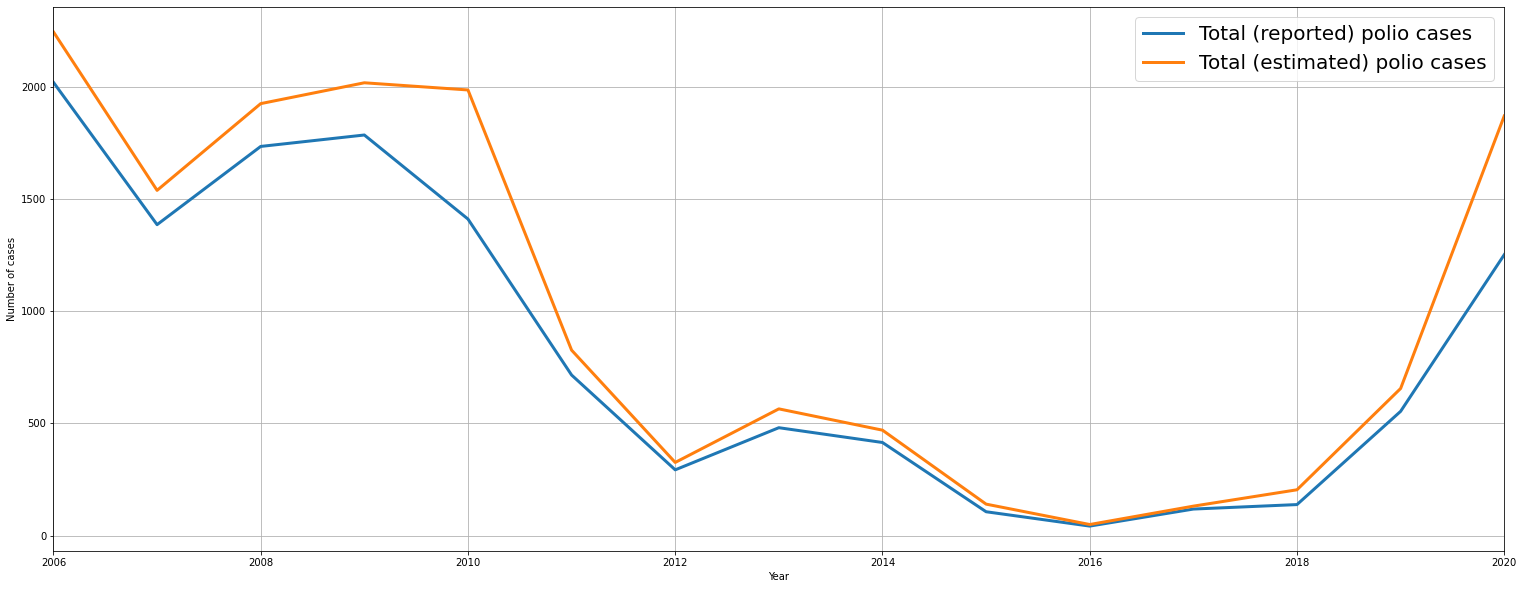

In [6]:
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(selected_world_data['Year'],selected_world_data['Total (reported) polio cases'],linewidth=3)
plt.plot(selected_world_data['Year'],selected_world_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(selected_world_data['Year']),max(selected_world_data['Year']))
plt.show()

As it can be seen in selected period of time, polio is growing rather than stopping

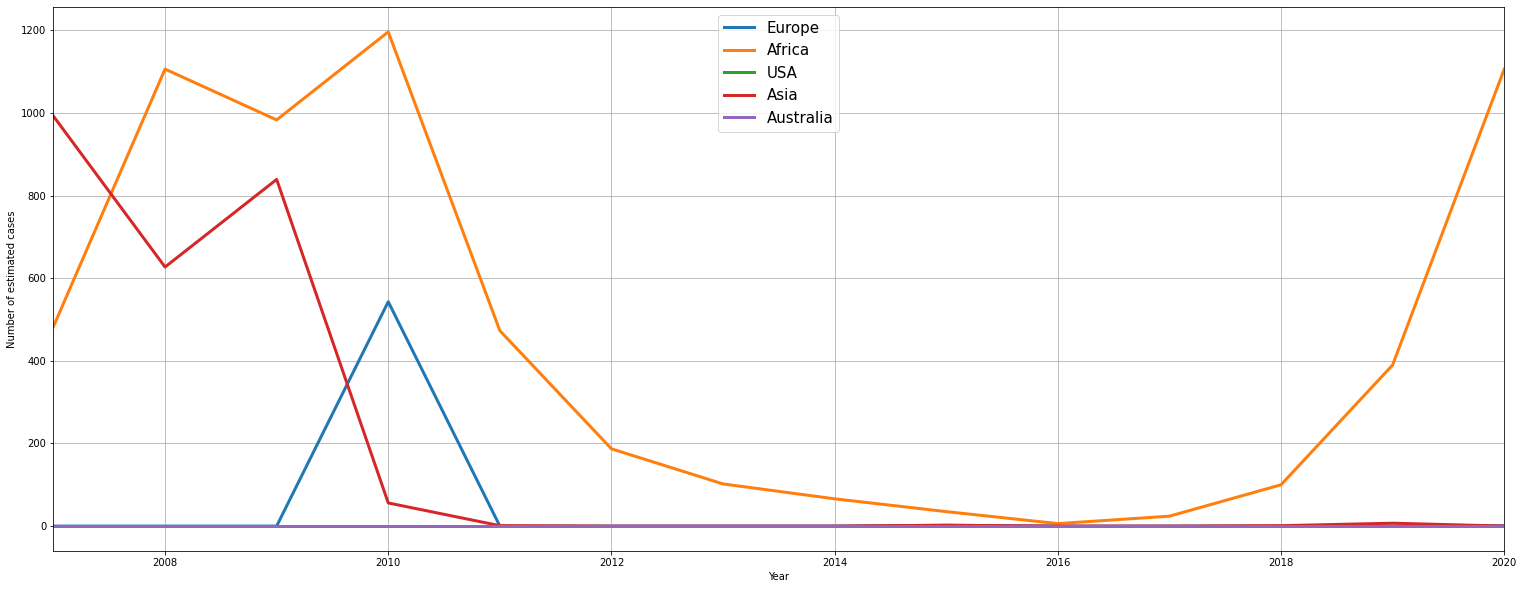

In [7]:
europe_selected_data = imported_data[imported_data['Entity'] == 'Europe'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
africa_selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
states_selected_data = imported_data[imported_data['Entity'] == 'United States'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
asia_selected_data = imported_data[imported_data['Entity'] == 'South-East Asia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
australia_selected_data = imported_data[imported_data['Entity'] == 'Australia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(europe_selected_data['Year'],europe_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(africa_selected_data['Year'],africa_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(states_selected_data['Year'],states_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(asia_selected_data['Year'],asia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(australia_selected_data['Year'],australia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Europe','Africa','USA','Asia','Australia'], prop={'size': 15})
plt.xlabel('Year')
plt.ylabel('Number of estimated cases')
plt.xlim(min(europe_selected_data['Year']),max(europe_selected_data['Year']))
plt.show()

As it can be seen problem is growing rapidly in Africa. So predictions will be made for Africa and whole world to see comparison.

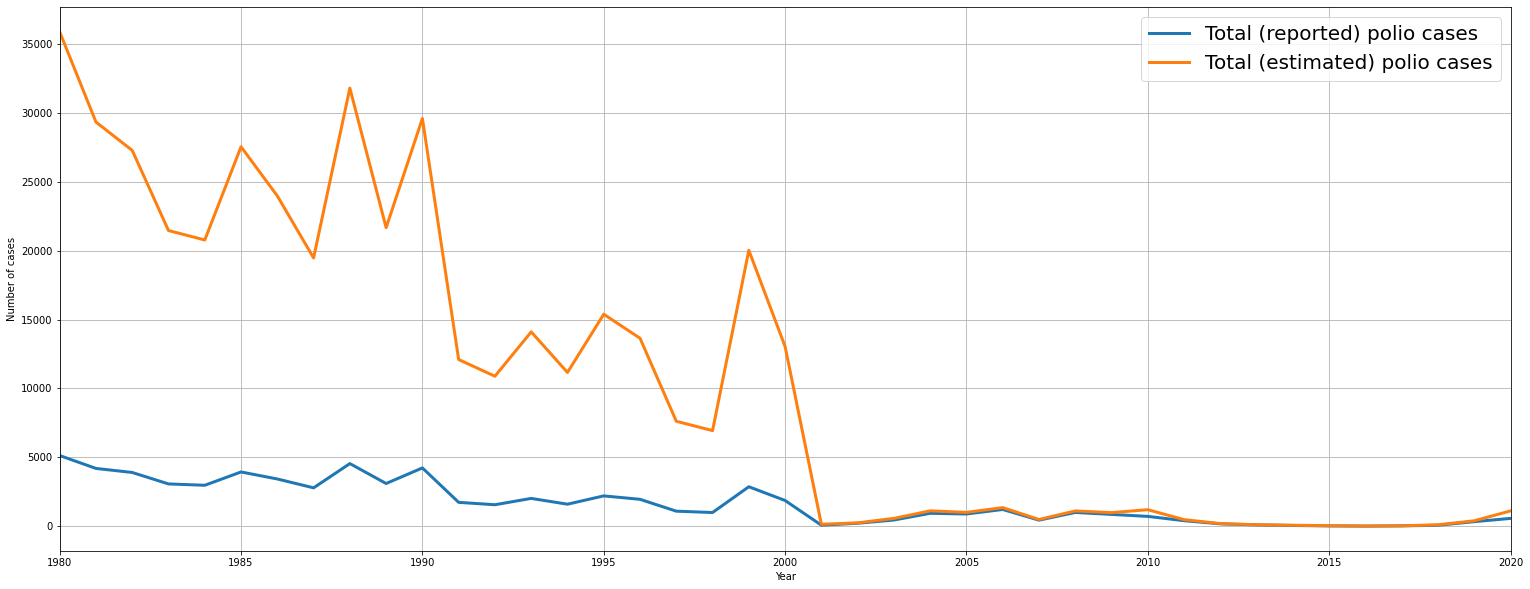

In [8]:
africa_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][:-1]
plt.figure(figsize=(26, 10))
plt.plot(africa_data['Year'],africa_data['Total (reported) polio cases'],linewidth=3)
plt.plot(africa_data['Year'],africa_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(africa_data['Year']),max(africa_data['Year']))
plt.grid(True)
plt.show()


Interesting region (last x years)

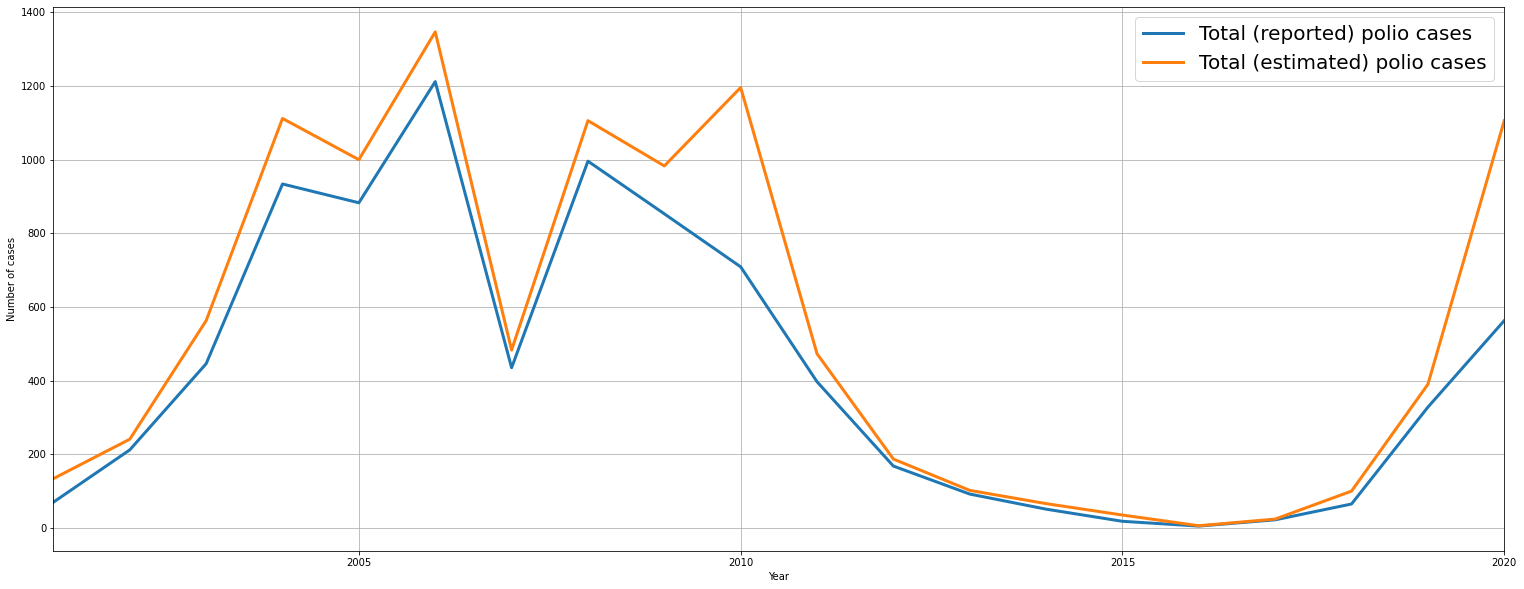

In [9]:
# Selecting data for analysis
n_years = 20
selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-n_years-1:-1]
selected_data.rename(columns = {'Total (reported) polio cases': 'Cases'}, inplace=True)
selected_data.rename(columns= {'Total (estimated) polio cases':'Cases_estimated'}, inplace=True)

plt.figure(figsize=(26, 10))
plt.grid(True)
plt.locator_params(axis="both", integer=True, tight=True)
plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
plt.plot(selected_data['Year'],selected_data['Cases_estimated'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
plt.show()

<h2>Model 1 - Linear regression</h2>
For first model linear regression will be used as it is most commonly programmed
problem is, with changing data scope, all priors must be changed
<br>
<h6>Reference:</h6>

In [70]:
stan_file = "stan_models\\linear_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
    int <lower = 0> N; 
    vector [N] y; //cases
    vector [N] x; //years
    int x_pred; //predicted year
    real prior_mu; // prior mean for alpha
    real prior_sigma;  // prior std for alpha
} 
 
parameters { 
    real alpha; 
    real beta; 
    real <lower = 0> sigma; 
} 
 
model { 
    alpha ~ normal(prior_mu, prior_sigma); 
    beta ~ normal(0, 3); //From research 
    sigma ~ exponential(0.01);
    y ~ normal(alpha + beta * x, sigma); 
} 

generated quantities{ 
  real y_pred = normal_rng(alpha + beta * x_pred, sigma);
} 


INFO:cmdstanpy:compiling stan file C:\Users\solar\Desktop\Studia\DataAnalysisProject\stan_models\linear_model.stan to exe file C:\Users\solar\Desktop\Studia\DataAnalysisProject\stan_models\linear_model.exe
INFO:cmdstanpy:compiled model executable: C:\Users\solar\Desktop\Studia\DataAnalysisProject\stan_models\linear_model.exe


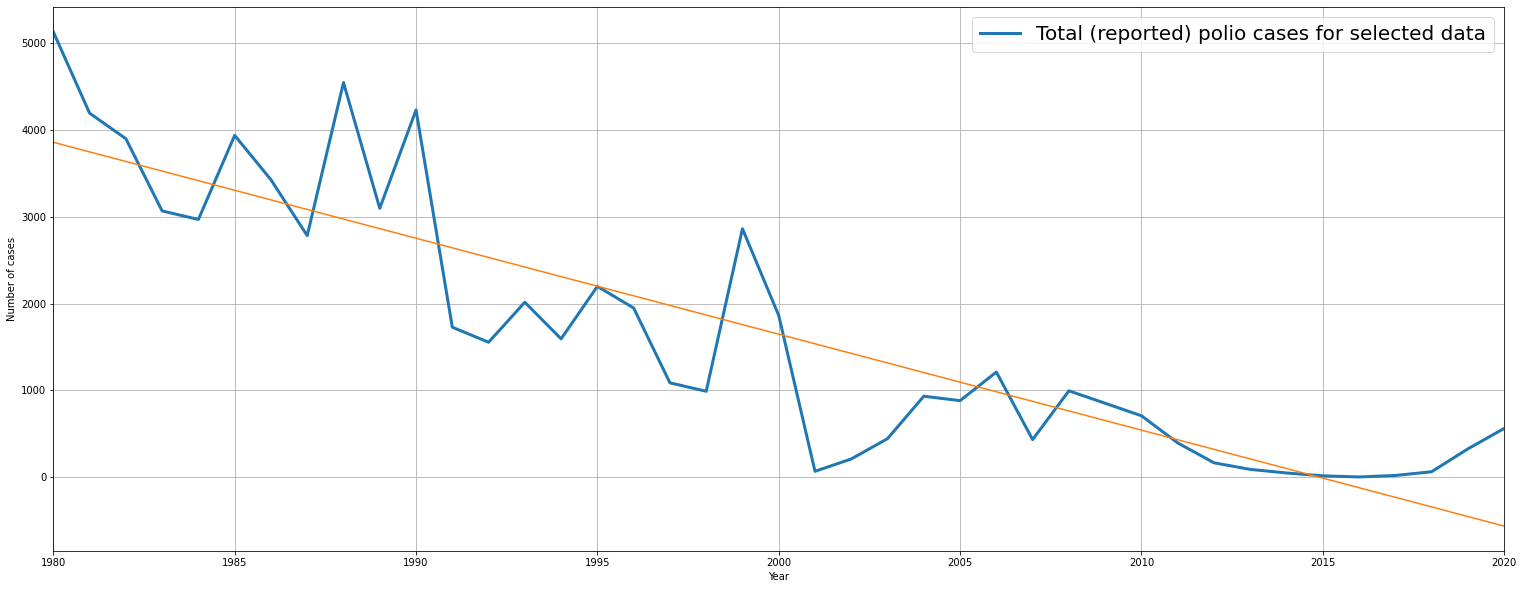

In [71]:
selected_data = select_data('Africa')
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


1647.7560975609756 1480.245872465323


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


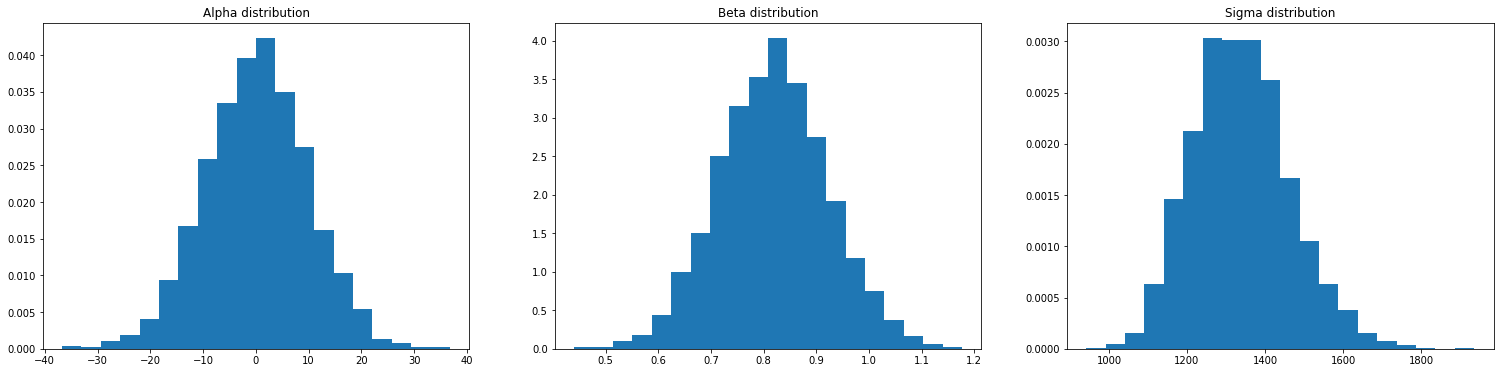

In [72]:
model_data_dict = {'N': len(selected_data),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'].iloc[-1] + 1,
                    'prior_mu': 0,
                    'prior_sigma': 10
                  }

print(np.mean(model_data_dict['y']),np.std(model_data_dict['y']))

fit = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [4] done processing


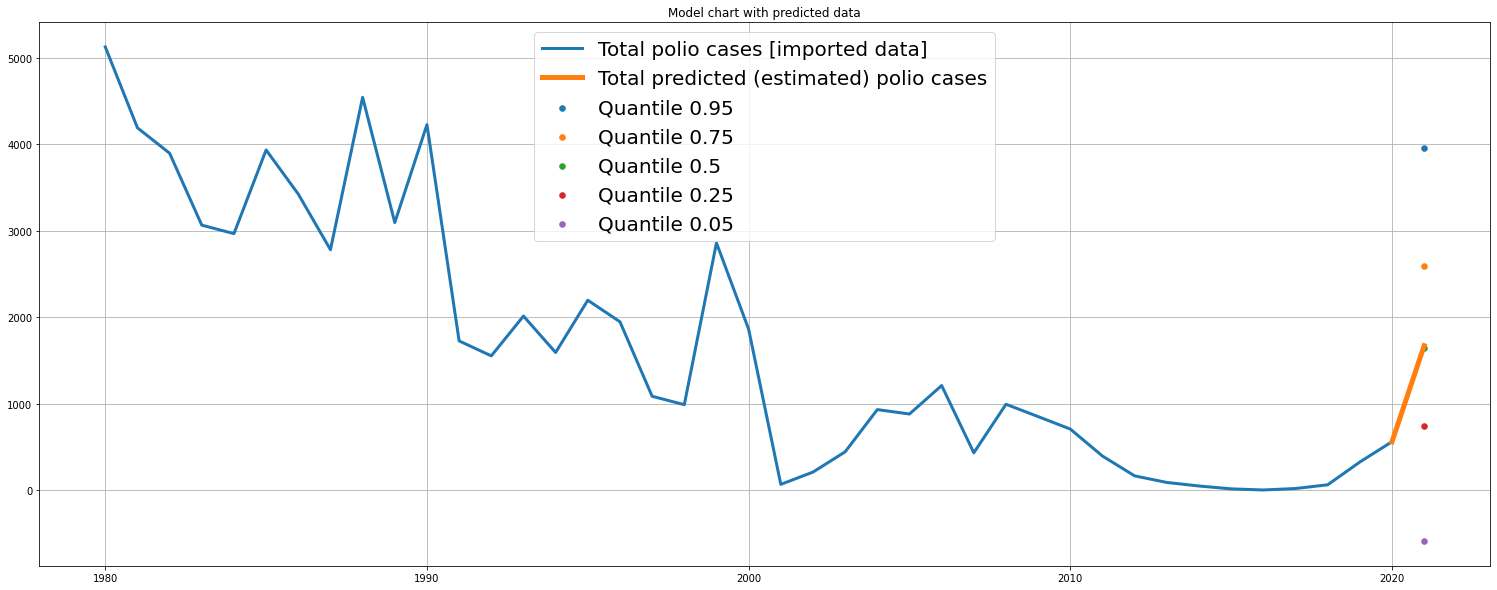

Predicted mean value of Polio cases for year 2021: 1673


In [73]:
prediction = model.generate_quantities(model_data_dict, fit)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021)

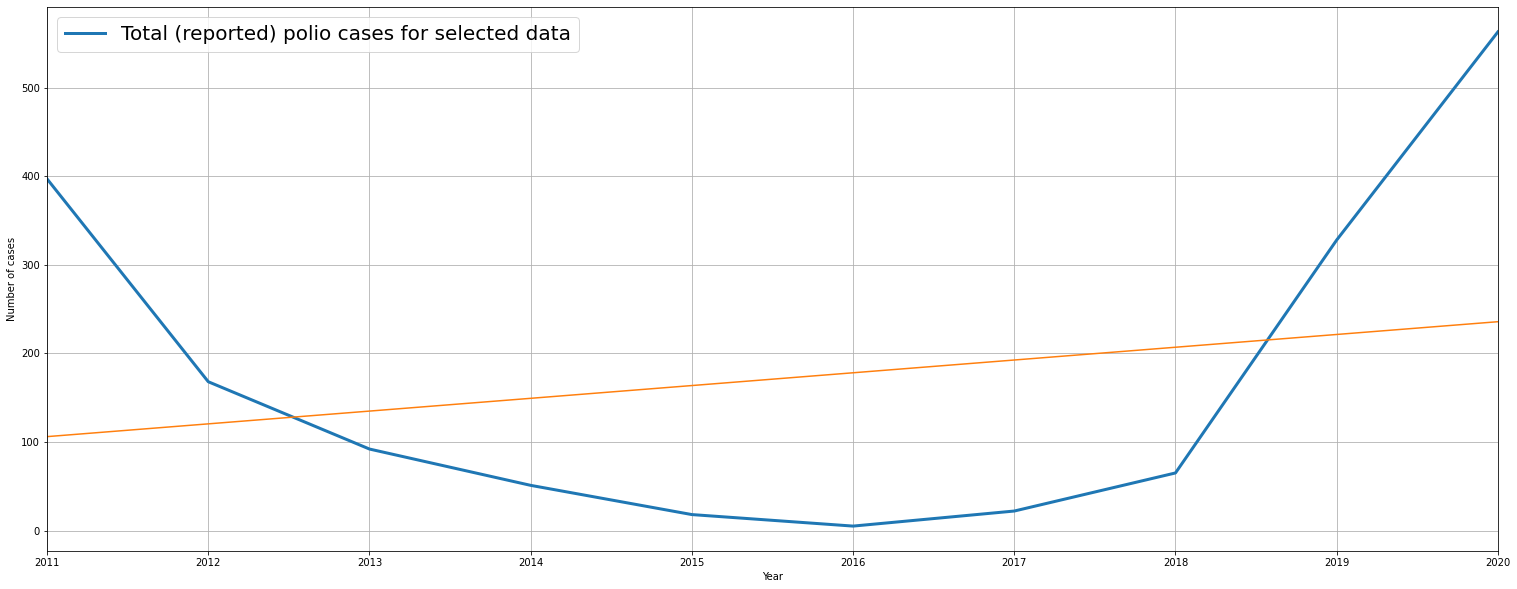

In [74]:
selected_data = select_data('Africa', 10)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


170.9 182.8772539163906


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


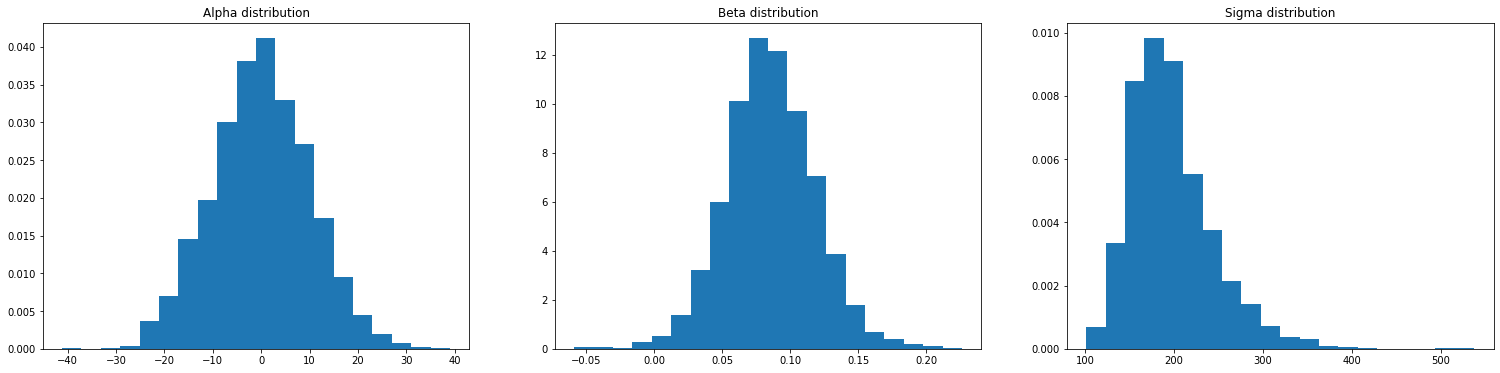

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


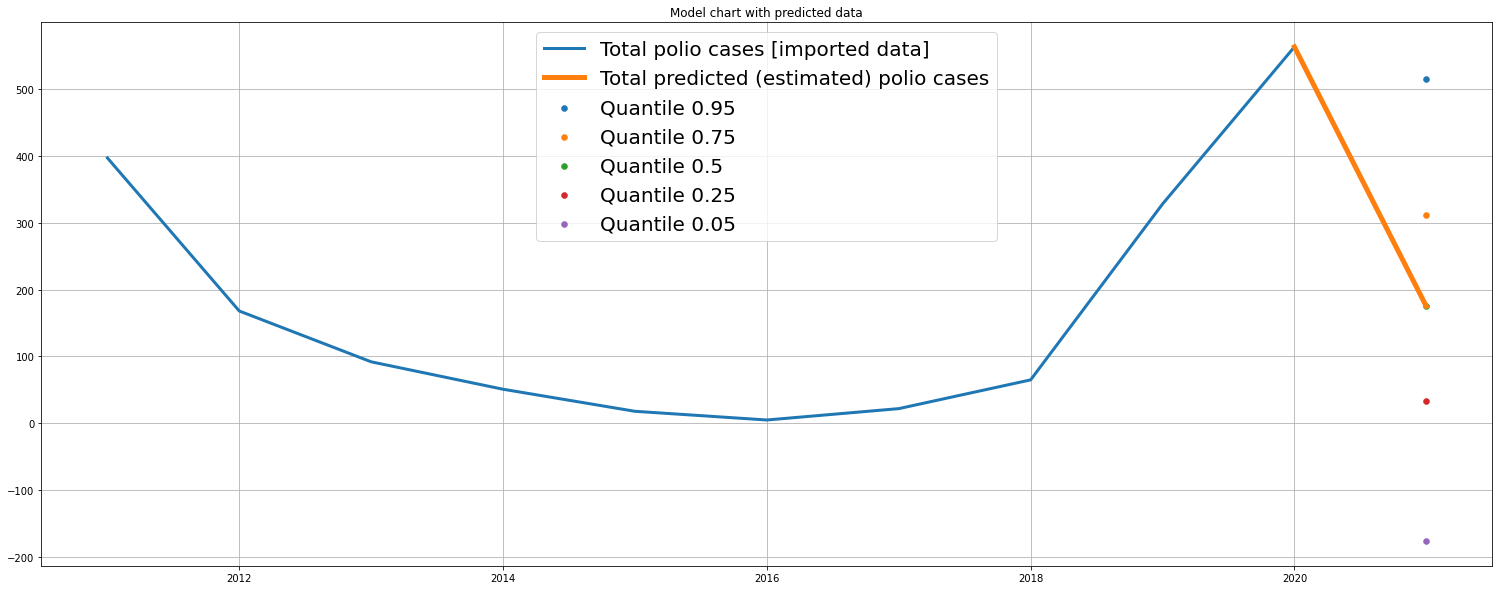

Predicted mean value of Polio cases for year 2021: 175


In [75]:
model_data_dict = {'N': len(selected_data),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'].iloc[-1] + 1,
                    'prior_mu': 0,
                    'prior_sigma': 10
                  }

print(np.mean(model_data_dict['y']),np.std(model_data_dict['y']))

fit = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit)
time.sleep(0.3)
prediction = model.generate_quantities(model_data_dict, fit)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021)

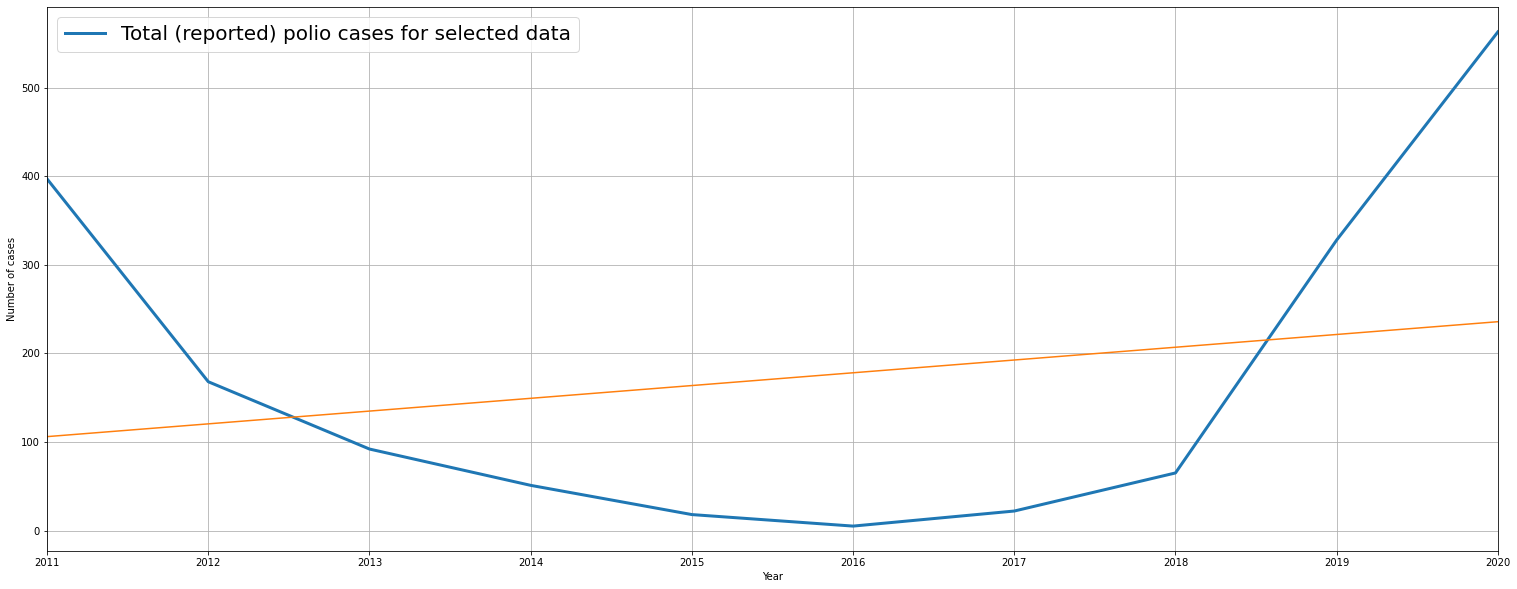

In [65]:
selected_data = select_data('Africa', 10)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


170.9 182.8772539163906


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


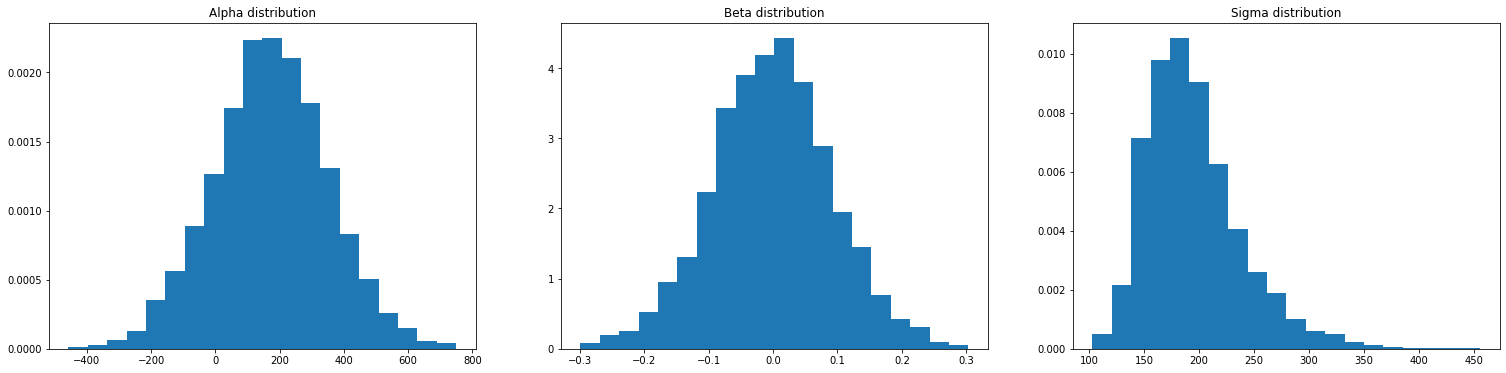

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


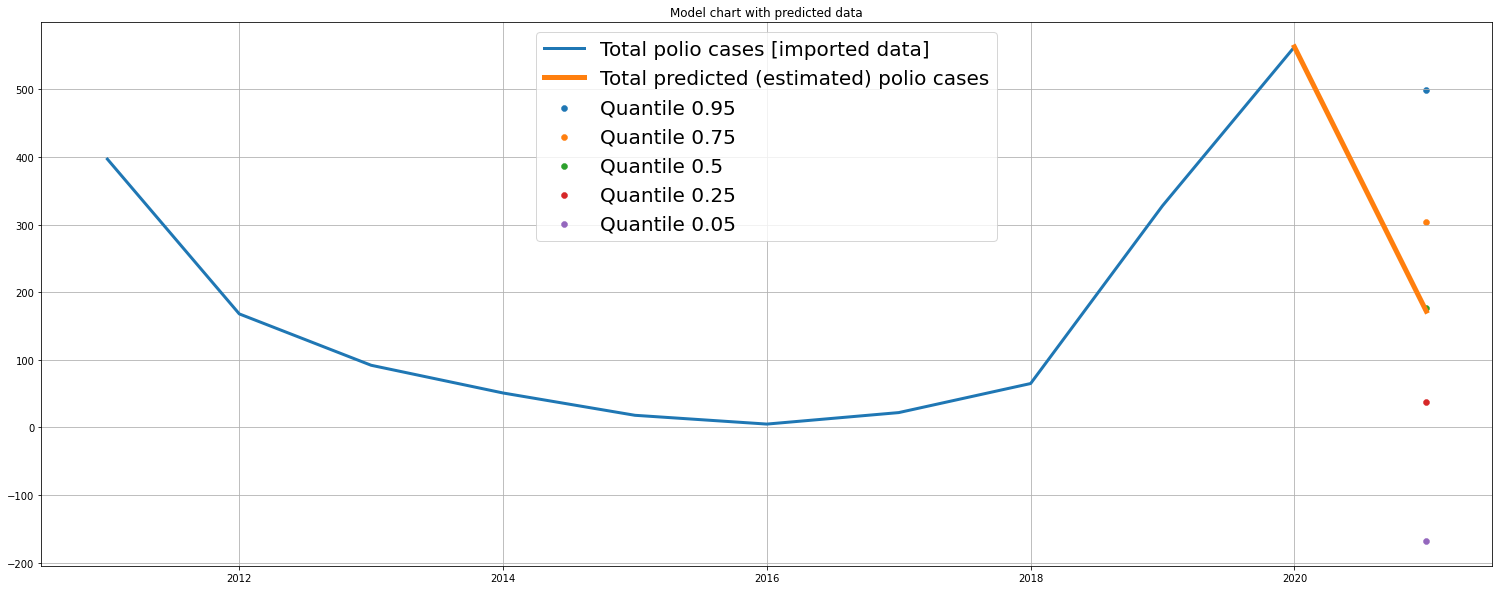

Predicted mean value of Polio cases for year 2021: 172


In [76]:
model_data_dict = {'N': len(selected_data),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'].iloc[-1] + 1,
                    'prior_mu': 170,
                    'prior_sigma': 180
                  }

print(np.mean(model_data_dict['y']),np.std(model_data_dict['y']))

fit = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit)
time.sleep(0.3)
prediction = model.generate_quantities(model_data_dict, fit)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021)

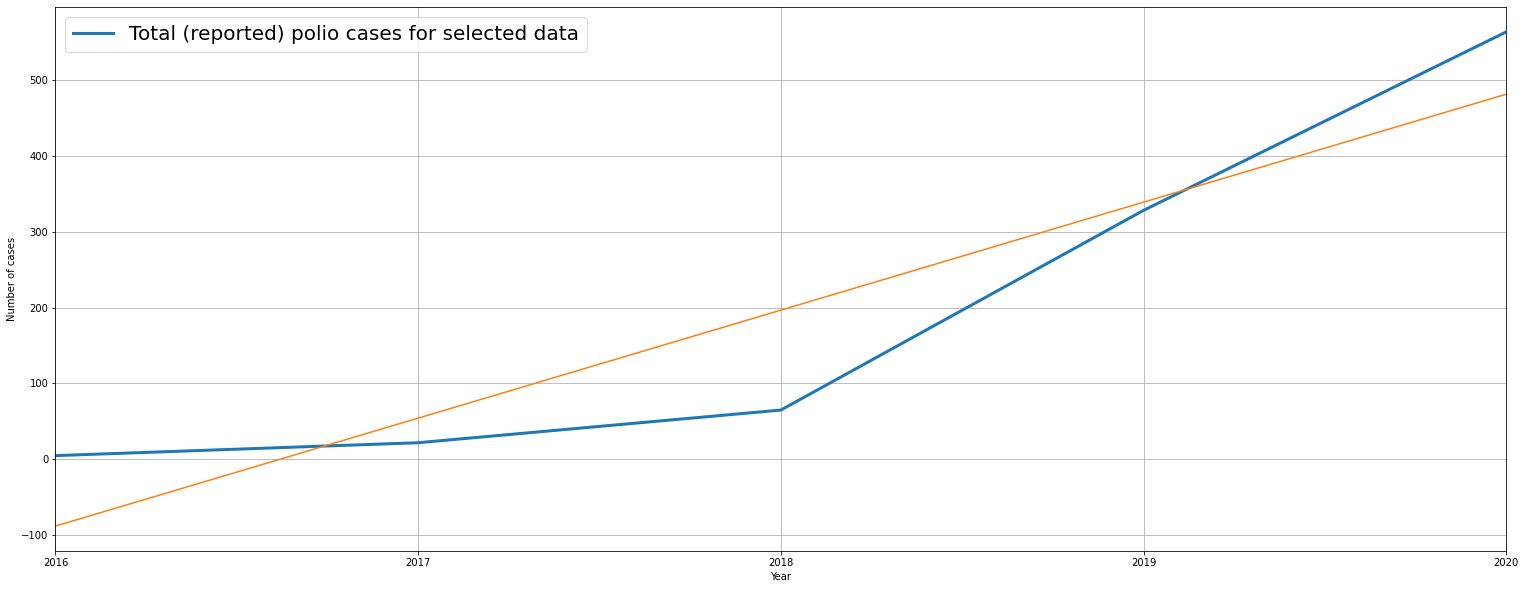

In [77]:
selected_data = select_data('Africa', 5)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


196.6 217.2690497977105


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


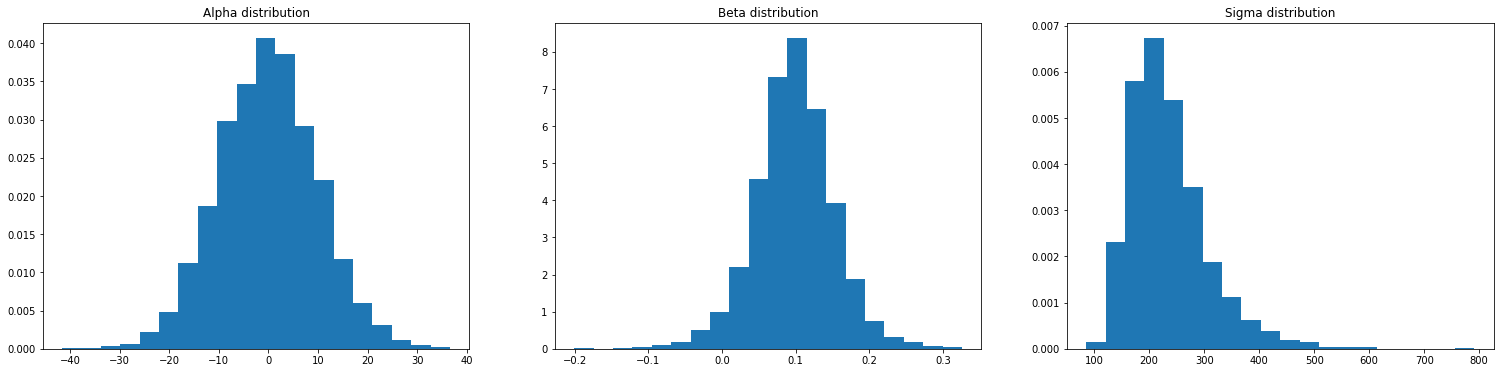

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


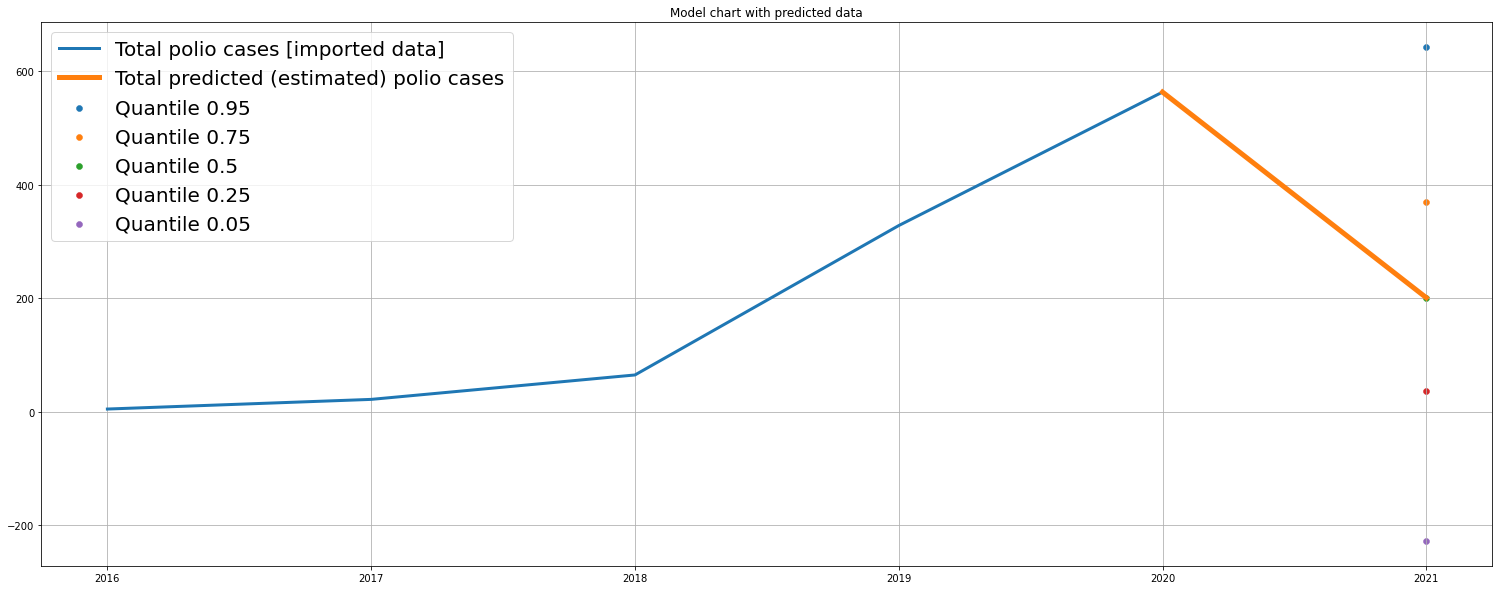

Predicted mean value of Polio cases for year 2021: 201


In [78]:
model_data_dict = {'N': len(selected_data),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'].iloc[-1] + 1,
                    'prior_mu': 196,
                    'prior_sigma': 217
                  }

print(np.mean(model_data_dict['y']),np.std(model_data_dict['y']))

fit = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit)
time.sleep(0.3)
prediction = model.generate_quantities(model_data_dict, fit)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021)

<h2>Model 2 - Autoregressive</h2>
As diesese is strictly connected with active infected people first model will be created on basis of autoregression
Model parameters will be generated by STAN model
<br>
<h6>Reference: https://mc-stan.org/docs/2_23/stan-users-guide/autoregressive-section.html</h6>

In [19]:
stan_file = "stan_models\\autoregressive_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
  int <lower = 0> N; 
  vector [N] y; 
} 
 
parameters { 
  real alpha; 
  real beta;
  real <lower = 0> sigma; 
} 
 
model { 
  for (n in 2:N){
    y[n] ~ normal(alpha + beta * y[n-1], sigma);
  }
} 

generated quantities{ 
  real y_pred = normal_rng(alpha + beta * y[N], sigma); 
} 



INFO:cmdstanpy:found newer exe file, not recompiling


Fitting model to whole avaiable data

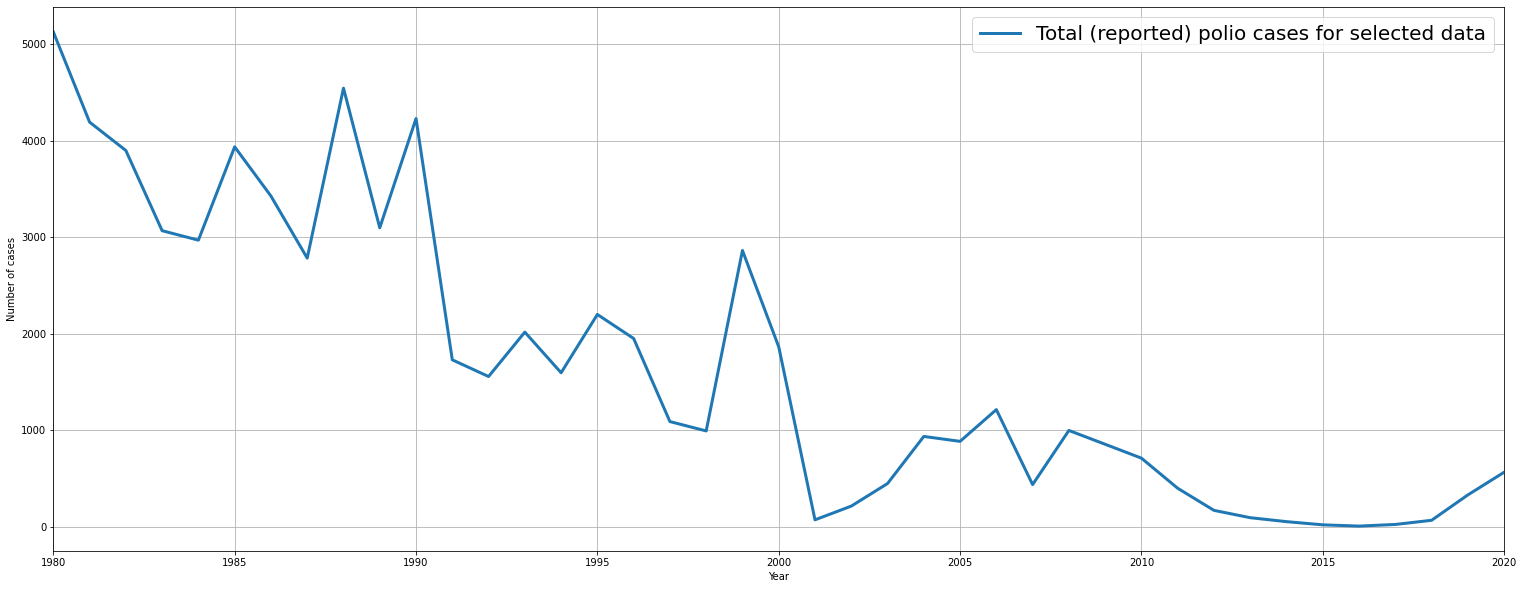

In [20]:
selected_data = select_data('Africa')
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


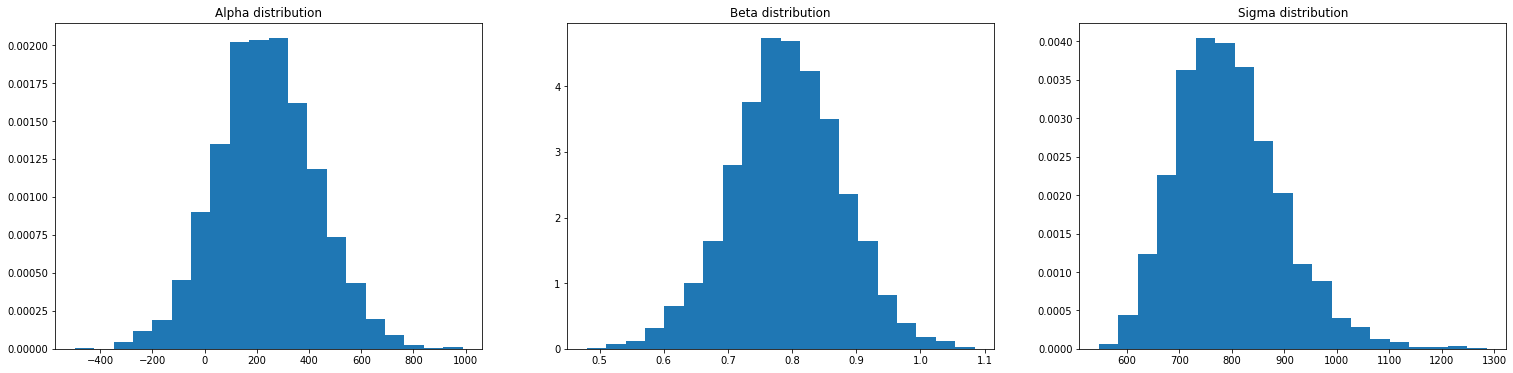

In [21]:
model_data_dict = {'N': len(selected_data),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                  }

fit = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [3] done processing


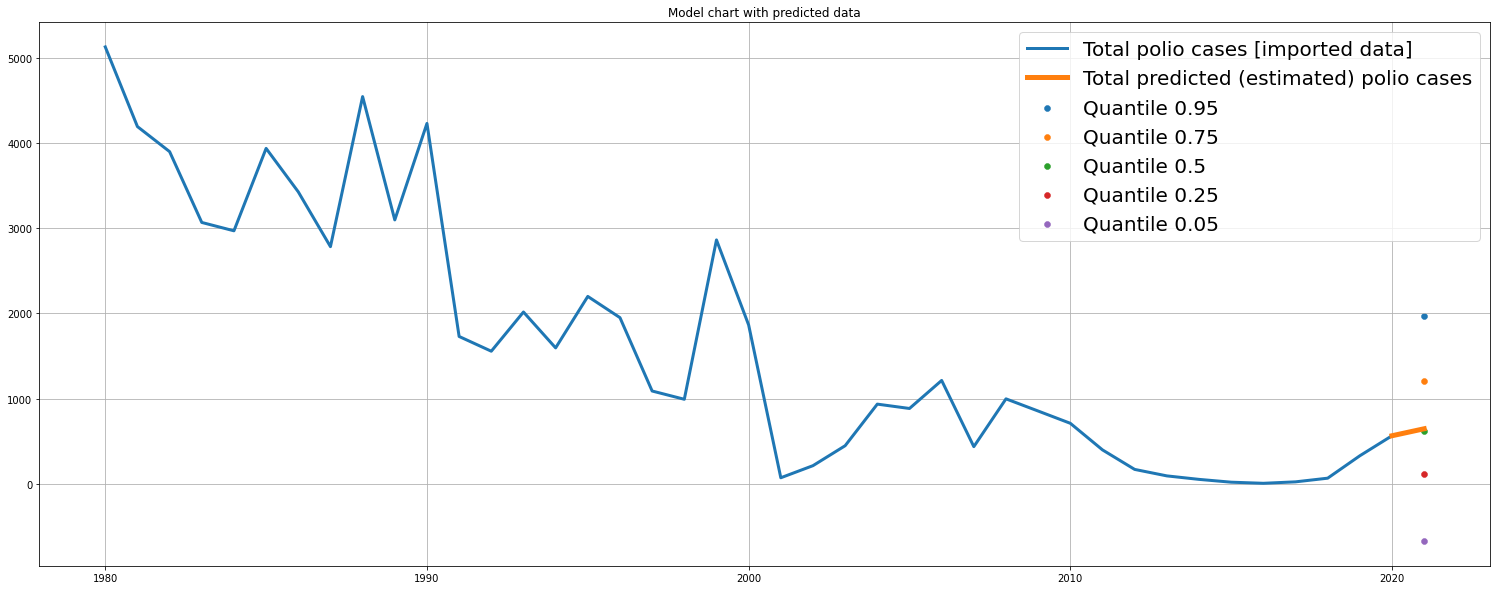

Predicted mean value of Polio cases for year 2021: 645


In [22]:
time.sleep(0.3)
prediction = model.generate_quantities(model_data_dict, fit)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021)

Predictions for last decade (u-shape)

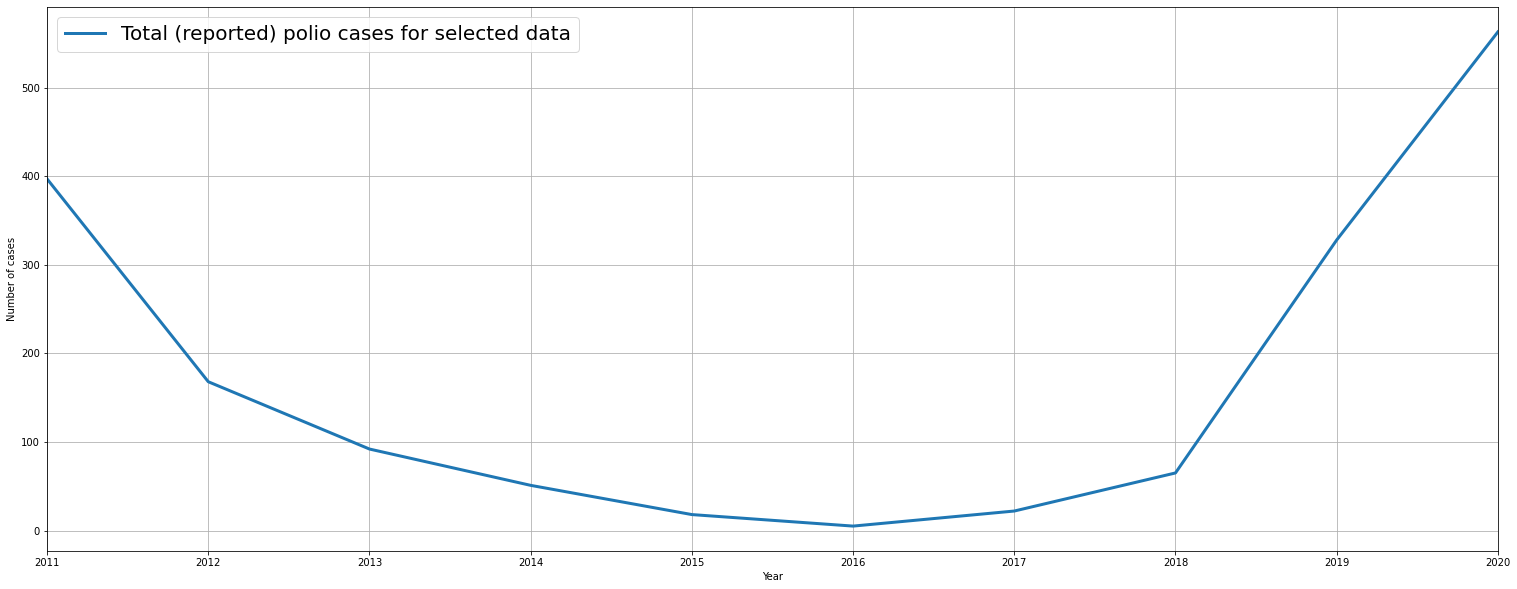

In [23]:
selected_data = select_data('Africa', 10)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


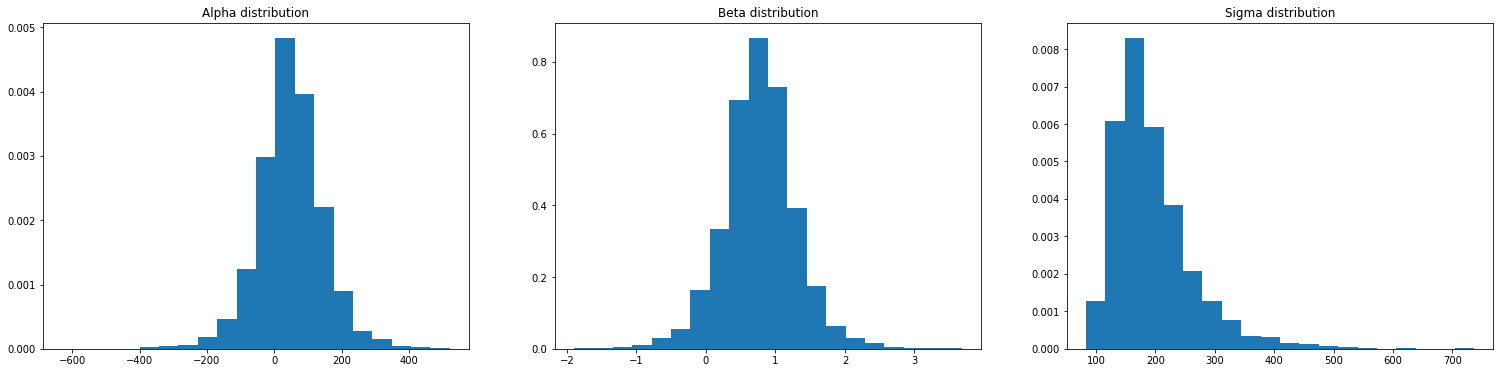

In [24]:
model_data_dict = {'N': len(selected_data),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                  }

fit = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [4] done processing


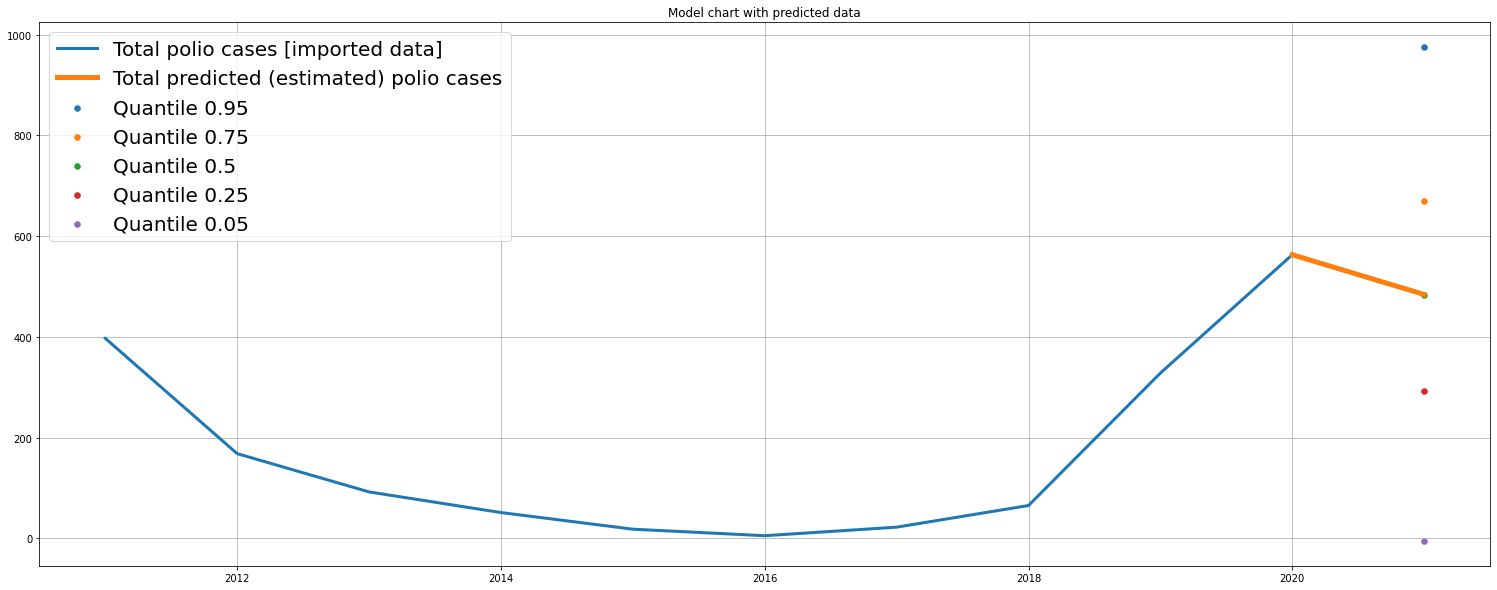

Predicted mean value of Polio cases for year 2021: 484


In [25]:
prediction = model.generate_quantities(model_data_dict, fit)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021)

Predictions for last 5 years (just going up)

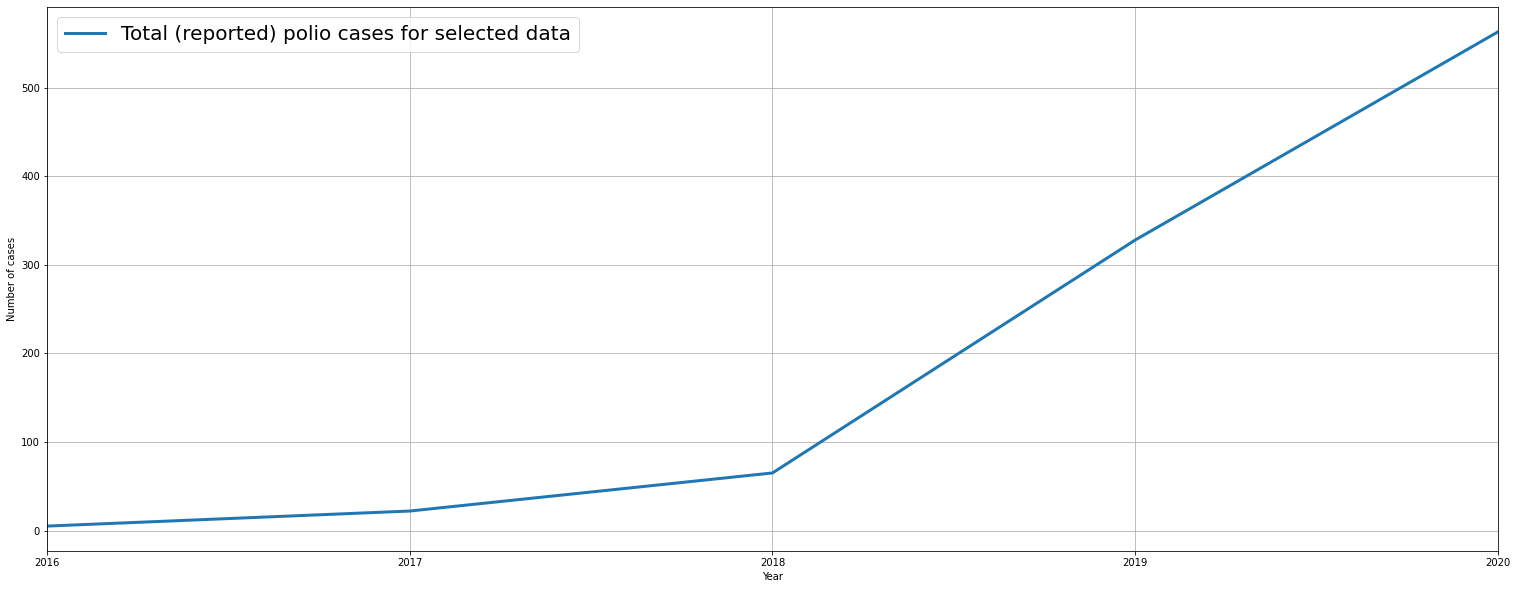

In [26]:
selected_data = select_data('Africa', 5)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


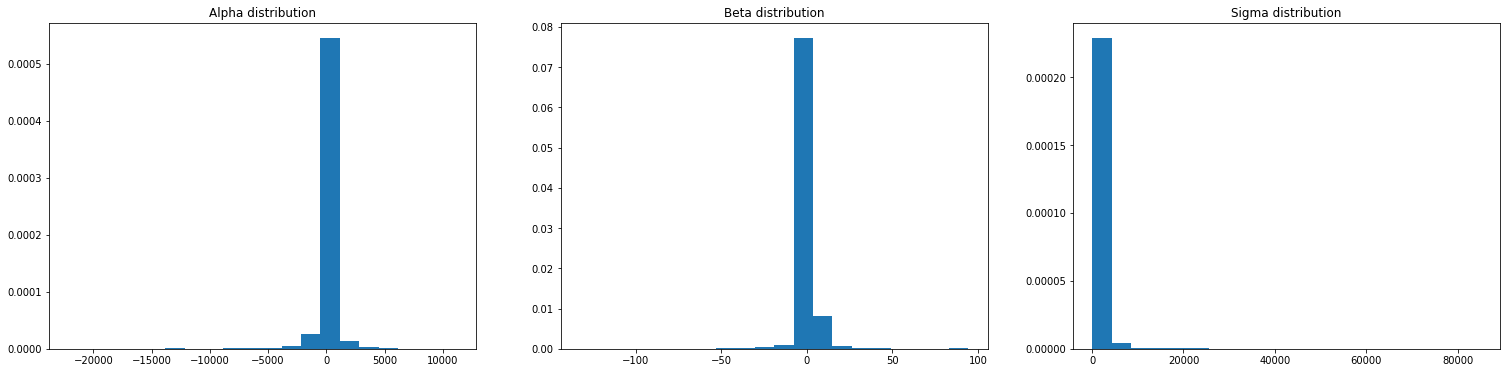

In [27]:
model_data_dict = {'N': len(selected_data),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                  }

fit = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit)

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing
INFO:cmdstanpy:Chain [2] done processing


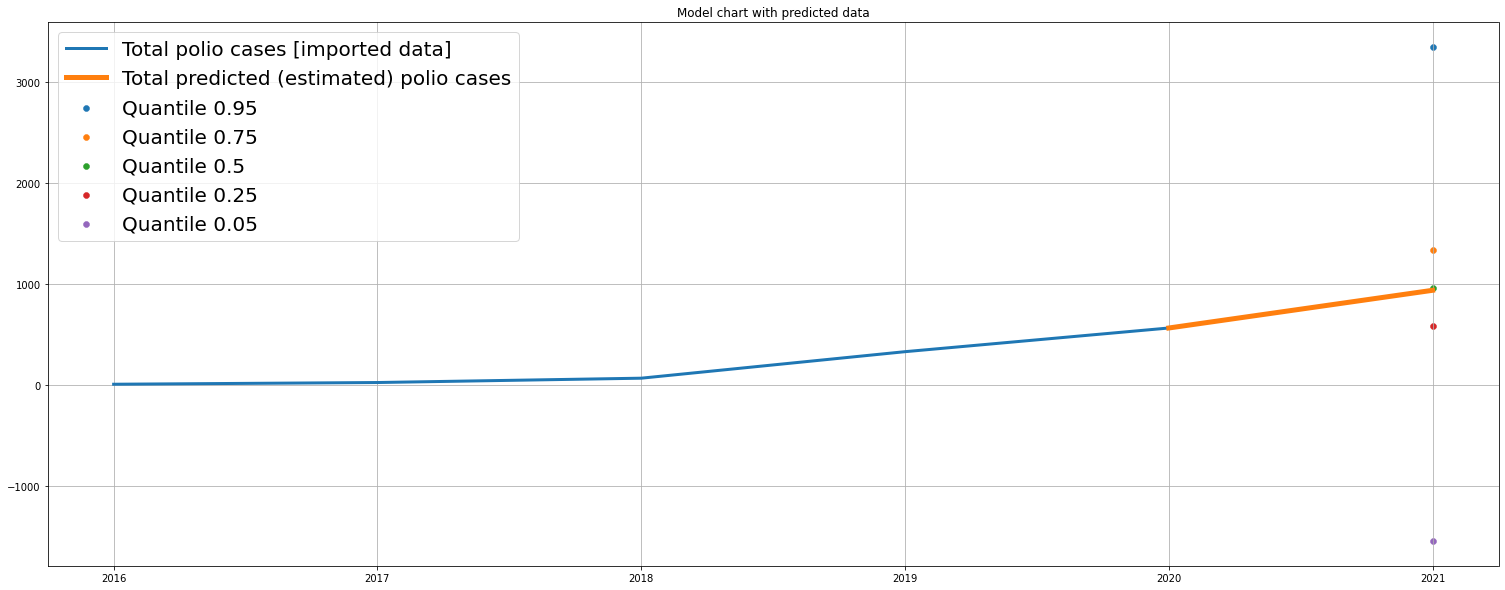

Predicted mean value of Polio cases for year 2021: 937


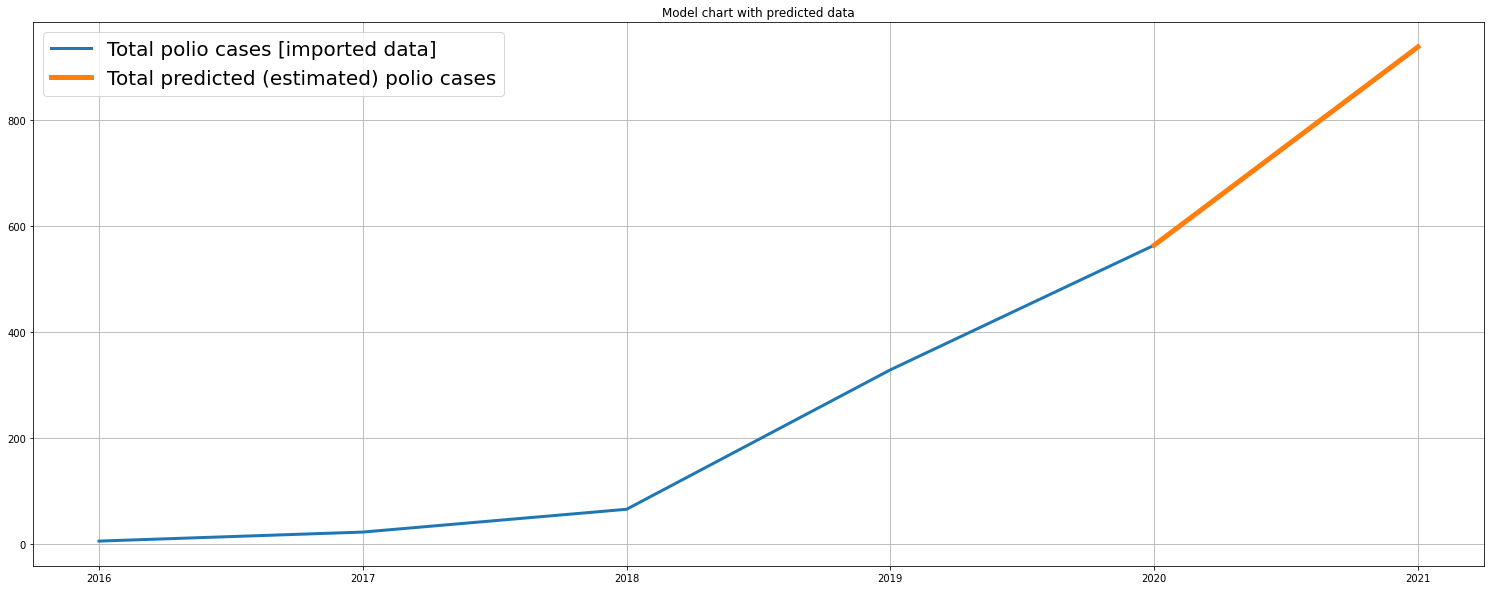

Predicted mean value of Polio cases for year 2021: 937


In [28]:
prediction = model.generate_quantities(model_data_dict, fit)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021)
plot_predictions_chart(selected_data, prediction.stan_variable('y_pred'), 2021, quantiles=False)